# 20230304_QIF_statistics_analysis

In [1]:
import sys
from pathlib import Path
import os
import warnings
import time
SPIKECOUNTER_PATH = os.getenv("SPIKECOUNTER_PATH")
ANALYSIS_OUTPUT_ROOTDIR = os.getenv("ANALYSIS_OUTPUT_ROOTDIR")
DATA_ROOTDIR = os.getenv("DATA_ROOTDIR")
sys.path.append(SPIKECOUNTER_PATH)

import matplotlib.pyplot as plt
from matplotlib import patches, lines
import matplotlib as mpl
import matplotlib.cm as cmaps
import matplotlib.colors as colors
from matplotlib import gridspec
import colorcet as cc
import mat73

from scipy import interpolate, signal, stats, optimize, ndimage
import scipy.io as scio
import numpy as np
import os
import skimage.io as skio
from skimage import measure
import parse

import pickle
import seaborn as sbs
import sys
from spikecounter.analysis import traces, images
from spikecounter import utils
from spikecounter.ui import visualize
from spikecounter.analysis import stats as sc_stats
from sklearn import neighbors
import lmfit
from cycler import cycler
import pandas as pd
import importlib
from statannotations.Annotator import Annotator
import subprocess
warnings.filterwarnings("once")
plt.style.use(
    os.path.join(SPIKECOUNTER_PATH, "config", "bio_publications.mplstyle")
)

In [2]:
rootdir = Path(ANALYSIS_OUTPUT_ROOTDIR, "2022 First Heartbeat_Submitted",
    "Figures/Data/Figure1")
expts = ["20210420_gcamp_widefield", \
         "20210716_gcamp_widefield", "20210724_gcamp_widefield"]
datadirs = [os.path.join(rootdir, d) for d in expts]
subfolder = "corrected"
output_datadir = Path(
    ANALYSIS_OUTPUT_ROOTDIR,
    "2022 First Heartbeat_Submitted",
    "Figures/Data/Figure2/QIF_comparison"
)
os.makedirs(output_datadir, exist_ok=True)

In [3]:
dFFs = []
offset_times = []
all_peaks = []
ts = []
total_embryos = 0
for datadir in datadirs:
    print(datadir)
    dFF_mat = scio.loadmat(os.path.join(datadir, "", "dFFs.mat"))
    print(dFF_mat.keys())
    print(dFF_mat['rois'])
    total_embryos += len(dFF_mat['rois'].ravel())
    offset_times.append(dFF_mat["offset_times"].ravel())
    curr_expt_peaks = pd.read_csv(os.path.join(datadir, "", "peaks_data.csv"), index_col="roi")
    curr_expt_peaks["t_rel_onset"] = 0
    curr_expt_peaks["peak_n"] = 0
    for i, idx in enumerate(curr_expt_peaks.index.unique()):
        curr_expt_peaks.loc[idx,"t_rel_onset"] = curr_expt_peaks.loc[idx,"t"] - dFF_mat["offset_times"].ravel()[i]
        curr_expt_peaks.loc[idx,"peak_n"] = np.arange(curr_expt_peaks.loc[idx].shape[0])

    all_peaks.append(curr_expt_peaks)
    dFFs.append(dFF_mat['dFF'])
    ts.append(dFF_mat['t'].ravel())

all_peaks_combined = []
total_indices = 0
for ap in all_peaks:
    curr_index = ap.index.unique()
    reindex = dict([(curr, i+total_indices) for i, curr in enumerate(curr_index)])
    all_peaks_combined.append(ap.rename(index=reindex))
    total_indices += len(curr_index)
all_peaks_combined = pd.concat(all_peaks_combined, axis=0)

/n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure1/20210420_gcamp_widefield
dict_keys(['__header__', '__version__', '__globals__', 'rois', 'offset_times', 'f_s', 'dFF', 't'])
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12]]
/n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure1/20210716_gcamp_widefield
dict_keys(['__header__', '__version__', '__globals__', 'rois', 'offset_times', 'f_s', 'dFF', 't'])
[[0 1 2 3 4 5 6 7 8]]
/n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure1/20210724_gcamp_widefield
dict_keys(['__header__', '__version__', '__globals__', 'rois', 'offset_times', 'f_s', 'dFF', 't'])
[[ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17]]


Sample particular peaks

In [4]:
peaks_by_n = all_peaks_combined.reset_index().set_index("peak_n")
isi_n = []
t_offset = []
n1 = 2
n2 = 50
# median_t_offset = np.zeros(n2-n1)
for n in range(n1, n2):
    isi_n.append(peaks_by_n.loc[n]["isi"])
    t_offset.append(peaks_by_n.loc[n]["t_rel_onset"])
isi_n = np.array(isi_n)
t_offset = np.array(t_offset)


In [5]:
median_t_offset = np.nanmedian(t_offset, axis=1)

Generate simulated peaks

In [6]:
test_moments = scio.loadmat(os.path.join(datadirs[0], "all_moments.mat"))
dt = np.diff(test_moments["hpf"].ravel())[0]
fit_params = np.load(os.path.join("/n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/", "QIF_individual_fits_5.npz"))
fit_params_opt = np.median(fit_params["beta_nm"][:,20], axis=0)
scale_factors = [1000,1/1.5,5]

In [7]:
median_t_offset/3600/dt

array([ 0.65      ,  1.26666667,  2.30555556,  2.93888889,  3.74444444,
        5.06666667,  6.20555556,  6.77777778,  8.59444444,  8.9       ,
        9.65      , 10.87222222, 11.16666667, 11.95      , 13.58888889,
       14.69444444, 15.64444444, 16.05555556, 16.75555556, 17.98888889,
       19.11666667, 19.66666667, 19.93333333, 20.28333333, 20.88888889,
       21.55      , 21.78888889, 22.15555556, 22.78333333, 23.07222222,
       23.26666667, 23.44444444, 23.86666667, 24.24444444, 24.73888889,
       25.42777778, 26.53333333, 27.31111111, 27.72777778, 27.82777778,
       28.00555556, 28.23888889, 29.29444444, 29.4       , 29.65      ,
       29.98333333, 30.10555556, 30.9       ])

In [16]:
fit_params_opt

array([ 1.16969759,  0.55548121, -0.1       ])

In [8]:
time_to_I = (median_t_offset/3600/dt)/scale_factors[0]*fit_params_opt[0] + fit_params_opt[2]/scale_factors[2]

In [23]:
np.mean(time_to_I)

0.0015912089806739383

In [102]:
sigma = 1.89
for I in time_to_I:
    command = ["matlab", "-nojvm", "-nosplash", "-nodesktop", "-nodisplay", "-r", \
               "addpath('../QIF_matlab'); single_sim_LIF_count_isis(%f, %f, 50000, 0.02, 1, \'%s\')" % (sigma, I, \
                                                os.path.join(output_data_dir, "bootstrap_histogram_sims"))]
    subprocess.run(command)


                            < M A T L A B (R) >
                  Copyright 1984-2021 The MathWorks, Inc.
                  R2021a (9.10.0.1602886) 64-bit (glnxa64)
                             February 17, 2021

 
For online documentation, see https://www.mathworks.com/support
For product information, visit www.mathworks.com.
 
   12.6721

>> 
                            < M A T L A B (R) >
                  Copyright 1984-2021 The MathWorks, Inc.
                  R2021a (9.10.0.1602886) 64-bit (glnxa64)
                             February 17, 2021

 
For online documentation, see https://www.mathworks.com/support
For product information, visit www.mathworks.com.
 
   13.8833

>> 
                            < M A T L A B (R) >
                  Copyright 1984-2021 The MathWorks, Inc.
                  R2021a (9.10.0.1602886) 64-bit (glnxa64)
                             February 17, 2021

 
For online documentation, see https://www.mathworks.com/support
For product information, v

 
For online documentation, see https://www.mathworks.com/support
For product information, visit www.mathworks.com.
 
   12.6666

>> 
                            < M A T L A B (R) >
                  Copyright 1984-2021 The MathWorks, Inc.
                  R2021a (9.10.0.1602886) 64-bit (glnxa64)
                             February 17, 2021

 
For online documentation, see https://www.mathworks.com/support
For product information, visit www.mathworks.com.
 
   12.5954

>> 
                            < M A T L A B (R) >
                  Copyright 1984-2021 The MathWorks, Inc.
                  R2021a (9.10.0.1602886) 64-bit (glnxa64)
                             February 17, 2021

 
For online documentation, see https://www.mathworks.com/support
For product information, visit www.mathworks.com.
 
   12.4400

>> 
                            < M A T L A B (R) >
                  Copyright 1984-2021 The MathWorks, Inc.
                  R2021a (9.10.0.1602886) 64-bit (glnxa64)
       

 
For online documentation, see https://www.mathworks.com/support
For product information, visit www.mathworks.com.
 
   14.8987

>> 

In [10]:
short_timescale_scaling = 1.4927431690592463
all_isis_sim = []
n_sample = 200
for f in os.listdir(os.path.join(output_datadir, "bootstrap_histogram_sims")):
    if ".mat" in f:
        sim_trace = scio.loadmat(os.path.join(output_datadir, "bootstrap_histogram_sims", f))
#         all_isis_sim.extend(sim_trace["isi"].ravel()[-n_sample:])
        I = parse.search("r_{:f}",f)[0]
        all_isis_sim.append((I, sim_trace["isi"].ravel()[-n_sample:]))
isis_sim_sorted = np.array(list(zip(*sorted(all_isis_sim, key=lambda x: x[0])))[1])

2.931139786367884
0.8451716800858569
3.767046686758734
0.8143335767384404
3.944175582259014
0.8020760117700905
4.119941309450879
0.8010756953298424
4.331872335631382
0.8006609619237388
4.4319446013154264
0.7956678586871961


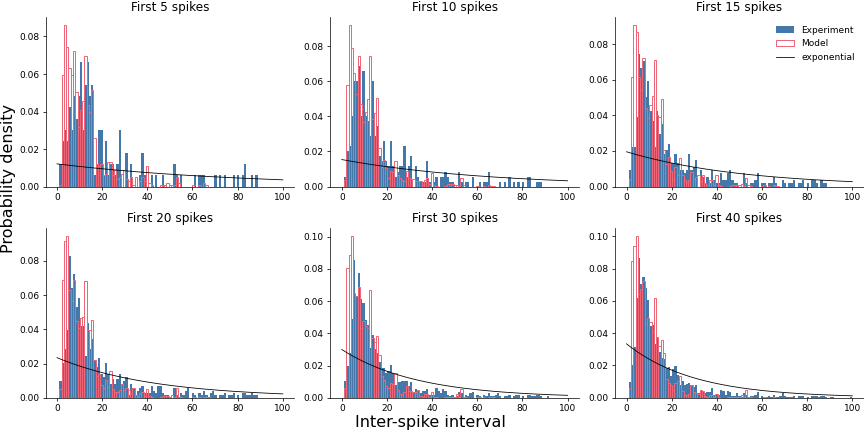

In [34]:
n_spikes = [5,10,15,20,30,40]
bl = 0
br = 100
n = 100
fig1, axes = plt.subplots(2, 3, figsize=(12,6))
axes = axes.ravel()
xs_exp = np.linspace(bl, br, 1000)

for idx, ns in enumerate(n_spikes):
    a = axes[idx].hist(isi_n[:ns].ravel()*short_timescale_scaling, bins=np.linspace(bl, br, n), density=True, label="Experiment")
    lambd = 1/np.mean(isi_n[:ns].ravel()*short_timescale_scaling)
    print(stats.variation(isi_n[:ns].ravel()))
    print(stats.variation(isis_sim_sorted[:ns].ravel()))

    ys_exp = lambd*np.exp(-lambd*xs_exp)
    b = axes[idx].hist(isis_sim_sorted[:ns].ravel(), \
                 bins=np.linspace(bl, br, n), facecolor=(0,0,0,0), edgecolor="C1", density=True, label="Model")
    axes[idx].plot(xs_exp, ys_exp, color="k", label="exponential")
    axes[idx].set_title("First %d spikes" % ns)
plt.tight_layout()
fig1.text(0.4, -0.01, "Inter-spike interval", fontsize=16)
fig1.text(-0.01, 0.4, "Probability density", rotation=90, fontsize=16)
axes[2].legend()
# plt.savefig(os.path.join(output_data_dir, "expt_sim_histogram_comparison.svg"))

4.119941309450879
0.8010756953298424


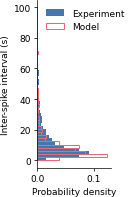

In [17]:
n_spikes = [5,10,15,20,30,40]
bl = 0
br = 100
n = 50
fig1, ax1 = plt.subplots(figsize=(1.8,3))

ns = 20
a = ax1.hist(isi_n[:ns].ravel(),
            bins=np.linspace(bl, br, n), density=True,
             label="Experiment", orientation="horizontal")
print(stats.variation(isi_n[:ns].ravel()))
print(stats.variation(isis_sim_sorted[:ns].ravel()))
b = ax1.hist(isis_sim_sorted[:ns].ravel()/short_timescale_scaling, \
             bins=np.linspace(bl, br, n), 
             facecolor=(0,0,0,0), edgecolor="C1",
             density=True, label="Model", orientation="horizontal")
ax1.set_ylabel("Inter-spike interval (s)")
ax1.set_xlabel("Probability density")
ax1.set_xlim(0, 0.13)
ax1.legend()
plt.tight_layout()
plt.savefig(output_datadir/"20_peaks_histogram_0.svg", dpi=300, bbox_inches="tight")

2.931139786367884
0.8451716800858569
3.767046686758734
0.8143335767384404
3.944175582259014
0.8020760117700905
4.119941309450879
0.8010756953298424
4.331872335631382
0.8006609619237388
4.4319446013154264
0.7956678586871961


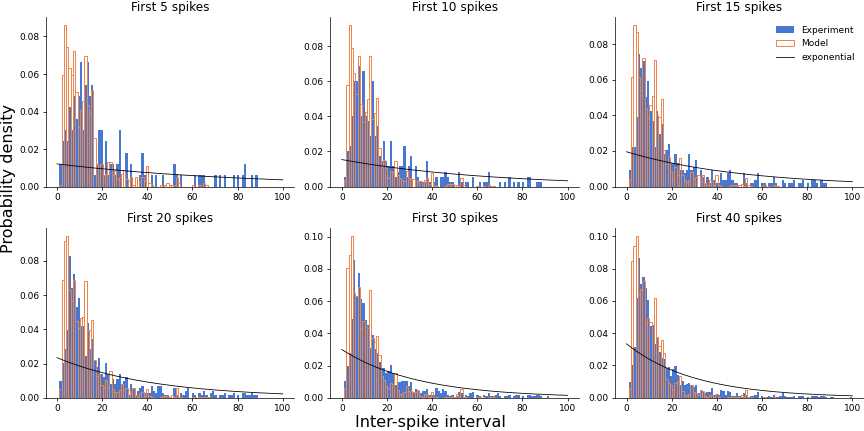

In [156]:
n_spikes = [5,10,15,20,30,40]
bl = 0
br = 100
n = 100
fig1, axes = plt.subplots(2, 3, figsize=(12,6))
axes = axes.ravel()
xs_exp = np.linspace(bl, br, 1000)

for idx, ns in enumerate(n_spikes):
    a = axes[idx].hist(isi_n[:ns].ravel()*short_timescale_scaling, bins=np.linspace(bl, br, n), density=True, label="Experiment")
    lambd = 1/np.mean(isi_n[:ns].ravel()*short_timescale_scaling)
    print(stats.variation(isi_n[:ns].ravel()))
    print(stats.variation(isis_sim_sorted[:ns].ravel()))

    ys_exp = lambd*np.exp(-lambd*xs_exp)
    b = axes[idx].hist(isis_sim_sorted[:ns].ravel(), \
                 bins=np.linspace(bl, br, n), facecolor=(0,0,0,0), edgecolor="C1", density=True, label="Model")
    axes[idx].plot(xs_exp, ys_exp, color="k", label="exponential")
    axes[idx].set_title("First %d spikes" % ns)
plt.tight_layout()
fig1.text(0.4, -0.01, "Inter-spike interval", fontsize=16)
fig1.text(-0.01, 0.4, "Probability density", rotation=90, fontsize=16)
axes[2].legend()
plt.savefig(os.path.join(output_data_dir, "expt_sim_histogram_comparison.svg"))

Now try for a few different values of x_reset

In [21]:
sigma = 1.89
reset_values = [-0.1, -0.2, -0.4]
for rs in reset_values:
    for I in time_to_I:
        out_dir = os.path.join(output_datadir, f"bootstrap_histogram_sims_{np.abs(rs)}")
#         print(out_dir)
        os.makedirs(out_dir, exist_ok=True)
        command = ["matlab", "-nojvm", "-nosplash", "-nodesktop", "-nodisplay", "-r", \
        f"addpath('../QIF_matlab'); single_sim_LIF_count_isis({sigma}, {I}, {rs}, 50000, 0.02, 1, '{str(out_dir)}')"]
        subprocess.run(command)

/n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure2/QIF_comparison/bootstrap_histogram_sims_0.1

                            < M A T L A B (R) >
                  Copyright 1984-2021 The MathWorks, Inc.
                  R2021a (9.10.0.1602886) 64-bit (glnxa64)
                             February 17, 2021

 
For online documentation, see https://www.mathworks.com/support
For product information, visit www.mathworks.com.
 
   17.6939

>> /n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure2/QIF_comparison/bootstrap_histogram_sims_0.1

                            < M A T L A B (R) >
                  Copyright 1984-2021 The MathWorks, Inc.
                  R2021a (9.10.0.1602886) 64-bit (glnxa64)
                             February 17, 2021

 
For online documentation, see https://www.mathworks.com/support
For product information, visit www.mathworks.com.
 
   18.0818

>> /n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Dat

 
For online documentation, see https://www.mathworks.com/support
For product information, visit www.mathworks.com.
 
   17.1800

>> /n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure2/QIF_comparison/bootstrap_histogram_sims_0.1

                            < M A T L A B (R) >
                  Copyright 1984-2021 The MathWorks, Inc.
                  R2021a (9.10.0.1602886) 64-bit (glnxa64)
                             February 17, 2021

 
For online documentation, see https://www.mathworks.com/support
For product information, visit www.mathworks.com.
 
   17.5556

>> /n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure2/QIF_comparison/bootstrap_histogram_sims_0.1

                            < M A T L A B (R) >
                  Copyright 1984-2021 The MathWorks, Inc.
                  R2021a (9.10.0.1602886) 64-bit (glnxa64)
                             February 17, 2021

 
For online documentation, see https://www.mathworks.com/support


 
For online documentation, see https://www.mathworks.com/support
For product information, visit www.mathworks.com.
 
   18.0422

>> /n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure2/QIF_comparison/bootstrap_histogram_sims_0.1

                            < M A T L A B (R) >
                  Copyright 1984-2021 The MathWorks, Inc.
                  R2021a (9.10.0.1602886) 64-bit (glnxa64)
                             February 17, 2021

 
For online documentation, see https://www.mathworks.com/support
For product information, visit www.mathworks.com.
 
   17.4546

>> /n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure2/QIF_comparison/bootstrap_histogram_sims_0.1

                            < M A T L A B (R) >
                  Copyright 1984-2021 The MathWorks, Inc.
                  R2021a (9.10.0.1602886) 64-bit (glnxa64)
                             February 17, 2021

 
For online documentation, see https://www.mathworks.com/support


 
For online documentation, see https://www.mathworks.com/support
For product information, visit www.mathworks.com.
 
   17.9367

>> /n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure2/QIF_comparison/bootstrap_histogram_sims_0.2

                            < M A T L A B (R) >
                  Copyright 1984-2021 The MathWorks, Inc.
                  R2021a (9.10.0.1602886) 64-bit (glnxa64)
                             February 17, 2021

 
For online documentation, see https://www.mathworks.com/support
For product information, visit www.mathworks.com.
 
   17.7083

>> /n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure2/QIF_comparison/bootstrap_histogram_sims_0.2

                            < M A T L A B (R) >
                  Copyright 1984-2021 The MathWorks, Inc.
                  R2021a (9.10.0.1602886) 64-bit (glnxa64)
                             February 17, 2021

 
For online documentation, see https://www.mathworks.com/support


 
For online documentation, see https://www.mathworks.com/support
For product information, visit www.mathworks.com.
 
   17.8787

>> /n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure2/QIF_comparison/bootstrap_histogram_sims_0.2

                            < M A T L A B (R) >
                  Copyright 1984-2021 The MathWorks, Inc.
                  R2021a (9.10.0.1602886) 64-bit (glnxa64)
                             February 17, 2021

 
For online documentation, see https://www.mathworks.com/support
For product information, visit www.mathworks.com.
 
   17.4573

>> /n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure2/QIF_comparison/bootstrap_histogram_sims_0.2

                            < M A T L A B (R) >
                  Copyright 1984-2021 The MathWorks, Inc.
                  R2021a (9.10.0.1602886) 64-bit (glnxa64)
                             February 17, 2021

 
For online documentation, see https://www.mathworks.com/support


 
For online documentation, see https://www.mathworks.com/support
For product information, visit www.mathworks.com.
 
   17.7194

>> /n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure2/QIF_comparison/bootstrap_histogram_sims_0.2

                            < M A T L A B (R) >
                  Copyright 1984-2021 The MathWorks, Inc.
                  R2021a (9.10.0.1602886) 64-bit (glnxa64)
                             February 17, 2021

 
For online documentation, see https://www.mathworks.com/support
For product information, visit www.mathworks.com.
 
   17.7736

>> /n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure2/QIF_comparison/bootstrap_histogram_sims_0.2

                            < M A T L A B (R) >
                  Copyright 1984-2021 The MathWorks, Inc.
                  R2021a (9.10.0.1602886) 64-bit (glnxa64)
                             February 17, 2021

 
For online documentation, see https://www.mathworks.com/support


 
For online documentation, see https://www.mathworks.com/support
For product information, visit www.mathworks.com.
 
   17.1227

>> /n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure2/QIF_comparison/bootstrap_histogram_sims_0.4

                            < M A T L A B (R) >
                  Copyright 1984-2021 The MathWorks, Inc.
                  R2021a (9.10.0.1602886) 64-bit (glnxa64)
                             February 17, 2021

 
For online documentation, see https://www.mathworks.com/support
For product information, visit www.mathworks.com.
 
   18.2100

>> /n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure2/QIF_comparison/bootstrap_histogram_sims_0.4

                            < M A T L A B (R) >
                  Copyright 1984-2021 The MathWorks, Inc.
                  R2021a (9.10.0.1602886) 64-bit (glnxa64)
                             February 17, 2021

 
For online documentation, see https://www.mathworks.com/support


 
For online documentation, see https://www.mathworks.com/support
For product information, visit www.mathworks.com.
 
   18.0589

>> /n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure2/QIF_comparison/bootstrap_histogram_sims_0.4

                            < M A T L A B (R) >
                  Copyright 1984-2021 The MathWorks, Inc.
                  R2021a (9.10.0.1602886) 64-bit (glnxa64)
                             February 17, 2021

 
For online documentation, see https://www.mathworks.com/support
For product information, visit www.mathworks.com.
 
   17.8667

>> /n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure2/QIF_comparison/bootstrap_histogram_sims_0.4

                            < M A T L A B (R) >
                  Copyright 1984-2021 The MathWorks, Inc.
                  R2021a (9.10.0.1602886) 64-bit (glnxa64)
                             February 17, 2021

 
For online documentation, see https://www.mathworks.com/support


 
For online documentation, see https://www.mathworks.com/support
For product information, visit www.mathworks.com.
 
   17.8221

>> 

In [18]:
short_timescale_scaling = 1.4927431690592463
all_isis_sim = []
n_sample = 200
sims_dir = output_datadir/"bootstrap_histogram_sims_0.1"
for f in os.listdir(sims_dir):
    if ".mat" in f:
        sim_trace = scio.loadmat(sims_dir/f)
#         all_isis_sim.extend(sim_trace["isi"].ravel()[-n_sample:])
        I = parse.search("r_{:f}",f)[0]
        all_isis_sim.append((I, sim_trace["isi"].ravel()[-n_sample:]))
isis_sim_sorted = np.array(list(zip(*sorted(all_isis_sim, key=lambda x: x[0])))[1])

4.119941309450879
0.7703455955685897


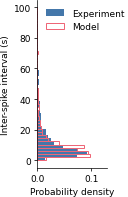

In [19]:
n_spikes = [5,10,15,20,30,40]
bl = 0
br = 100
n = 50
fig1, ax1 = plt.subplots(figsize=(1.75,3))

ns = 20
a = ax1.hist(isi_n[:ns].ravel(),
            bins=np.linspace(bl, br, n), density=True,
             label="Experiment", orientation="horizontal")
print(stats.variation(isi_n[:ns].ravel()))
print(stats.variation(isis_sim_sorted[:ns].ravel()))
b = ax1.hist(isis_sim_sorted[:ns].ravel()/short_timescale_scaling, \
             bins=np.linspace(bl, br, n), 
             facecolor=(0,0,0,0), edgecolor="C1",
             density=True, label="Model", orientation="horizontal")
ax1.set_ylabel("Inter-spike interval (s)")
ax1.set_xlabel("Probability density")
ax1.legend()
ax1.set_xlim(0, 0.13)
plt.tight_layout()
plt.savefig(output_datadir/"20_peaks_histogram_-0.1.svg", dpi=300, bbox_inches="tight")

In [20]:
short_timescale_scaling = 1.4927431690592463
all_isis_sim = []
n_sample = 200
sims_dir = output_datadir/"bootstrap_histogram_sims_0.2"
for f in os.listdir(sims_dir):
    if ".mat" in f:
        sim_trace = scio.loadmat(sims_dir/f)
#         all_isis_sim.extend(sim_trace["isi"].ravel()[-n_sample:])
        I = parse.search("r_{:f}",f)[0]
        all_isis_sim.append((I, sim_trace["isi"].ravel()[-n_sample:]))
isis_sim_sorted = np.array(list(zip(*sorted(all_isis_sim, key=lambda x: x[0])))[1])

4.119941309450879
0.7322219478519273


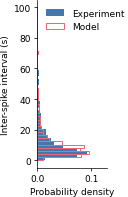

In [21]:
n_spikes = [5,10,15,20,30,40]
bl = 0
br = 100
n = 50
fig1, ax1 = plt.subplots(figsize=(1.75,3))

ns = 20
a = ax1.hist(isi_n[:ns].ravel(),
            bins=np.linspace(bl, br, n), density=True,
             label="Experiment", orientation="horizontal")
print(stats.variation(isi_n[:ns].ravel()))
print(stats.variation(isis_sim_sorted[:ns].ravel()))
b = ax1.hist(isis_sim_sorted[:ns].ravel()/short_timescale_scaling, \
             bins=np.linspace(bl, br, n), 
             facecolor=(0,0,0,0), edgecolor="C1",
             density=True, label="Model", orientation="horizontal")
ax1.set_ylabel("Inter-spike interval (s)")
ax1.set_xlabel("Probability density")
ax1.set_xlim(0, 0.13)
ax1.legend()
plt.tight_layout()
plt.savefig(output_datadir/"20_peaks_histogram_-0.2.svg", dpi=300, bbox_inches="tight")

In [16]:
short_timescale_scaling = 1.4927431690592463
isi_sim_dfs = []
n_sample = 200
for x_reset in [0, 0.1, 0.2]:
    all_isis_sim = []
    sims_dir = output_datadir/f"bootstrap_histogram_sims_{x_reset}"
    for f in os.listdir(sims_dir):
        if ".mat" in f:
            sim_trace = scio.loadmat(sims_dir/f)
    #         all_isis_sim.extend(sim_trace["isi"].ravel()[-n_sample:])
            I = parse.search("r_{:f}",f)[0]
            all_isis_sim.append((I, sim_trace["isi"].ravel()[-n_sample:]))
        
    isis_sim_sorted = np.array(list(zip(*sorted(all_isis_sim, key=lambda x: x[0])))[1])
    df = pd.DataFrame(isis_sim_sorted/short_timescale_scaling, columns=[f"isi_{i}" for i in range(isis_sim_sorted.shape[1])])
    df["I"] = I
    df["x_reset"] = -x_reset
    isi_sim_dfs.append(df)

In [17]:
isi_sim_df = pd.concat(isi_sim_dfs, axis=0)

In [18]:
isi_sim_df.to_csv(output_datadir/"simulated_spike_histograms.csv")

In [15]:
isi_n.shape

(48, 39)

In [21]:
ns = 20
expt_isi_df = pd.DataFrame(isi_n[:ns].T, columns=[f"isi_{i}" for i in range(ns)])

In [22]:
expt_isi_df.to_csv(output_datadir/"expt_spike_histograms.csv")